<a href="https://colab.research.google.com/github/Yassineka99/E-Commerce-Web-Application-Deployment-Using-Docker-and-Nginx/blob/main/Analysis_of_E_commerce_Sales_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up the environment

Data link : https://www.kaggle.com/code/niteshyadav3103/eda-e-commerce-shipping-data/input

In [ ]:
!pip install pyspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install findspark

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("E-commerce Sales Analysis") \
    .getOrCreate()


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Train.csv to Train.csv


In [ ]:
import pandas as pd
from io import StringIO

# Read the uploaded file into a Pandas DataFrame
data_pd = pd.read_csv(StringIO(uploaded[next(iter(uploaded))].decode('utf-8')))

# Convert the Pandas DataFrame to a PySpark DataFrame
data = spark.createDataFrame(data_pd)

#Data Preprocessing

##Removing Duplicates:

In [ ]:
data = data.dropDuplicates()

##Data Type Conversion

In [ ]:
from pyspark.sql.functions import col
data = data.withColumn("Warehouse_block", col("Warehouse_block").cast("string")) \
           .withColumn("Mode_of_Shipment", col("Mode_of_Shipment").cast("string")) \
           .withColumn("Product_importance", col("Product_importance").cast("string")) \
           .withColumn("Gender", col("Gender").cast("string"))

data.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Warehouse_block: string (nullable = true)
 |-- Mode_of_Shipment: string (nullable = true)
 |-- Customer_care_calls: long (nullable = true)
 |-- Customer_rating: long (nullable = true)
 |-- Cost_of_the_Product: long (nullable = true)
 |-- Prior_purchases: long (nullable = true)
 |-- Product_importance: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Discount_offered: long (nullable = true)
 |-- Weight_in_gms: long (nullable = true)
 |-- Reached.on.Time_Y.N: long (nullable = true)



##Data Exploration and Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

###Distribution of Customer Ratings

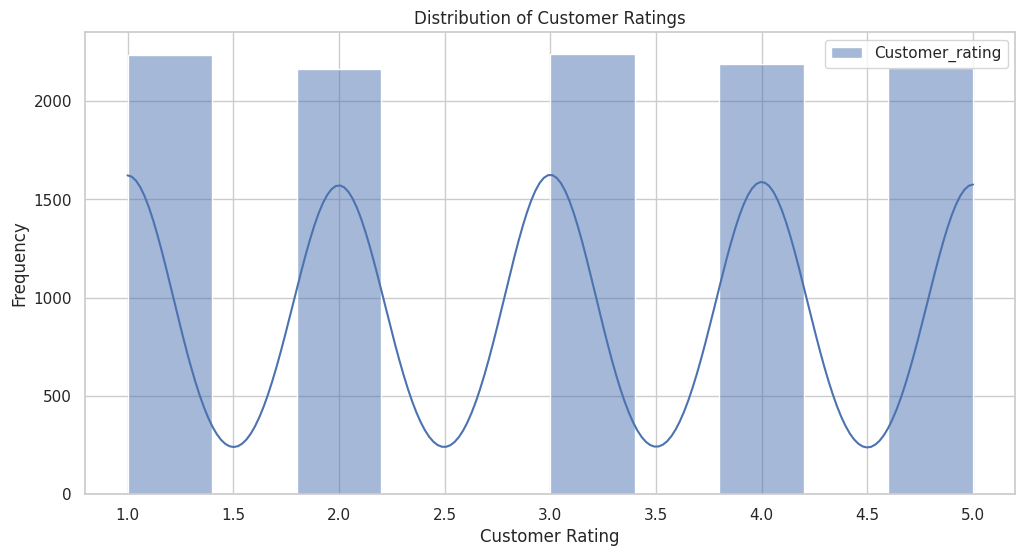

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data.select("Customer_rating").toPandas(), bins=10, kde=True, color='blue')
plt.title("Distribution of Customer Ratings")
plt.xlabel("Customer Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

###Count of Items Purchased by Gender

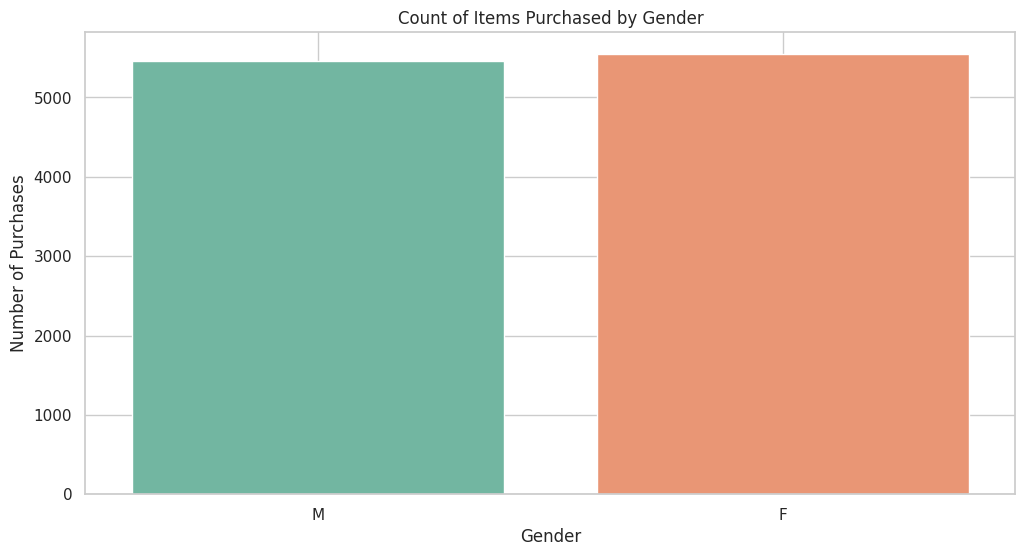

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Gender', data=data.toPandas(), hue='Gender', palette='Set2', legend=False)
plt.title("Count of Items Purchased by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Purchases")
plt.grid(True)
plt.show()

###Average Purchase Amount by Category

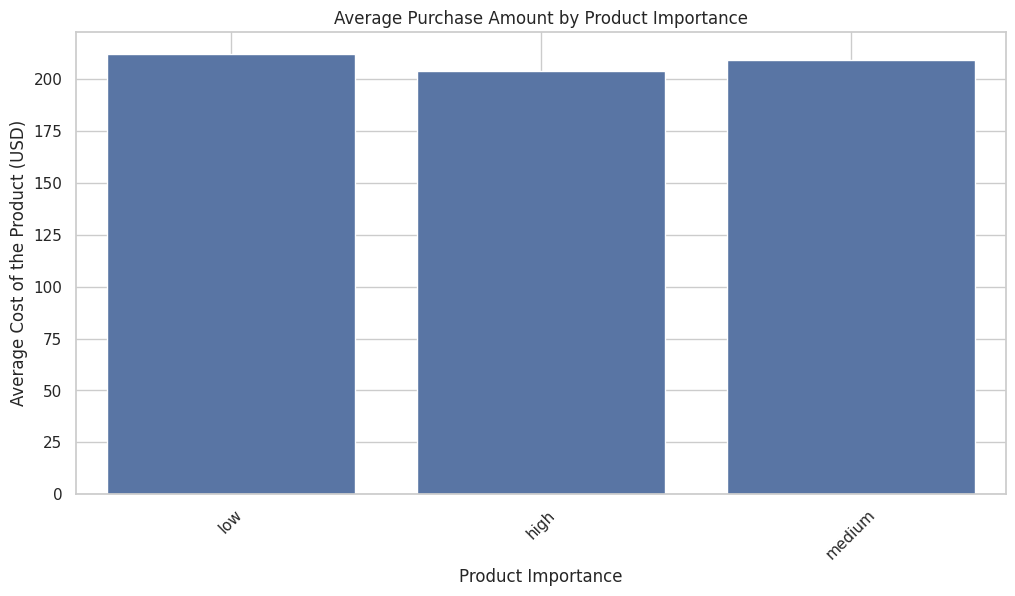

In [ ]:
from pyspark.sql import functions as F

plt.figure(figsize=(12, 6))
avg_purchase = data.groupBy("Product_importance").agg(F.mean("Cost_of_the_Product").alias("Average_Cost")).toPandas()
sns.barplot(x='Product_importance', y='Average_Cost', data=avg_purchase)
plt.title("Average Purchase Amount by Product Importance")
plt.xlabel("Product Importance")
plt.ylabel("Average Cost of the Product (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

###Average customer ratings based on prior purchases

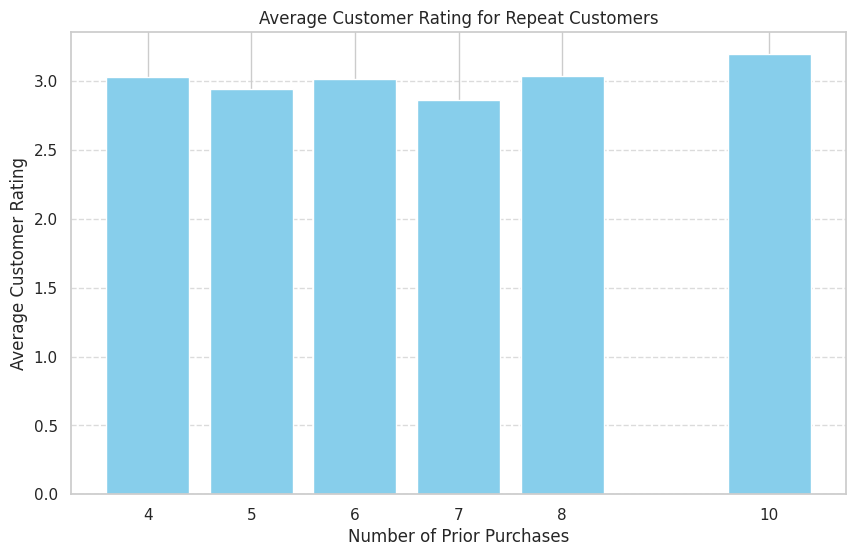

In [ ]:
avg_rating = data.groupBy("Prior_purchases").agg(F.avg("Customer_rating").alias("avg_customer_rating"))
repeat_customers_rating = avg_rating.filter(avg_rating.Prior_purchases > 3)
repeat_customers_pd = repeat_customers_rating.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(repeat_customers_pd['Prior_purchases'], repeat_customers_pd['avg_customer_rating'], color='skyblue')
plt.title('Average Customer Rating for Repeat Customers')
plt.xlabel('Number of Prior Purchases')
plt.ylabel('Average Customer Rating')
plt.xticks(repeat_customers_pd['Prior_purchases'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Impact of Discounts

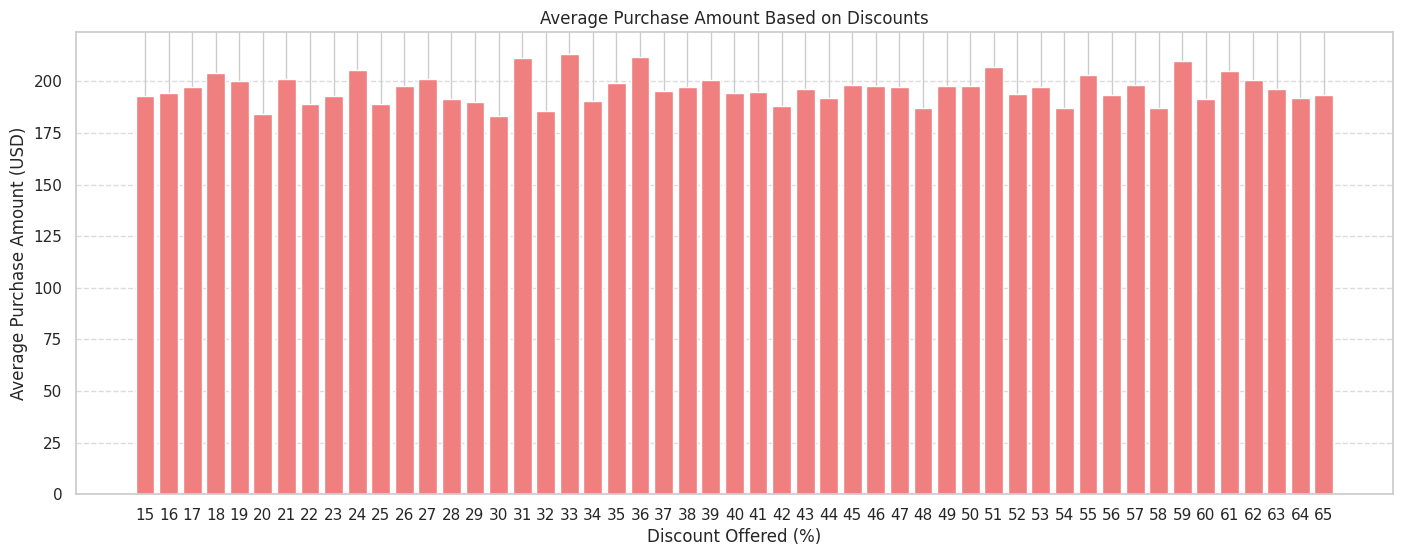

In [ ]:

avg_discount_impact = data.groupBy("Discount_offered").agg(F.avg("Cost_of_the_Product").alias("avg_purchase_amount"))
significant_discounts = avg_discount_impact.filter(avg_discount_impact.Discount_offered >= 15)
significant_discounts_pd = significant_discounts.toPandas()
plt.figure(figsize=(17, 6))
plt.bar(significant_discounts_pd['Discount_offered'], significant_discounts_pd['avg_purchase_amount'], color='lightcoral')
plt.title('Average Purchase Amount Based on Discounts')
plt.xlabel('Discount Offered (%)')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(significant_discounts_pd['Discount_offered'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###Shipping Preferences

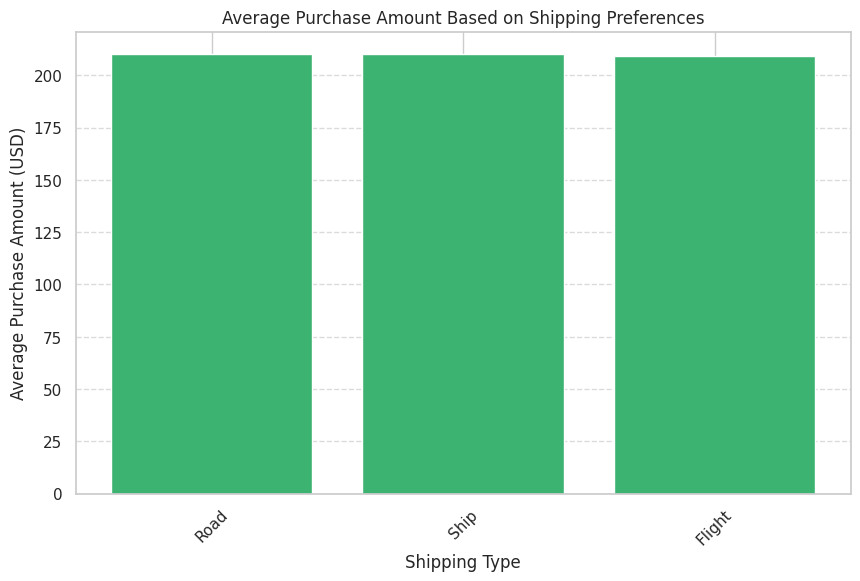

In [ ]:
avg_shipping_preferences = data.groupBy("Mode_of_Shipment").agg(F.avg("Cost_of_the_Product").alias("avg_purchase_amount"))
avg_shipping_preferences_pd = avg_shipping_preferences.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(avg_shipping_preferences_pd['Mode_of_Shipment'], avg_shipping_preferences_pd['avg_purchase_amount'], color='mediumseagreen')
plt.title('Average Purchase Amount Based on Shipping Preferences')
plt.xlabel('Shipping Type')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###Warehouse Block Performance

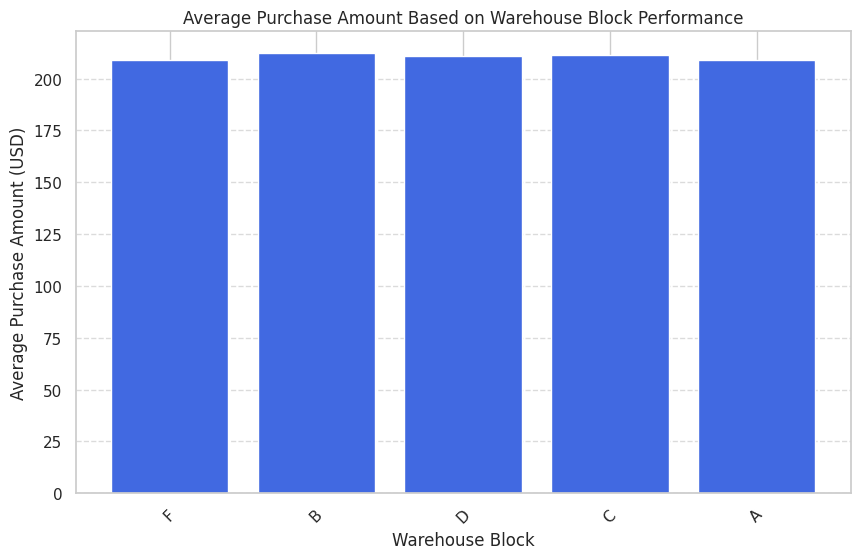

In [ ]:
avg_warehouse_performance = data.groupBy("Warehouse_block").agg(F.avg("Cost_of_the_Product").alias("avg_purchase_amount"))
avg_warehouse_performance_pd = avg_warehouse_performance.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(avg_warehouse_performance_pd['Warehouse_block'], avg_warehouse_performance_pd['avg_purchase_amount'], color='royalblue')
plt.title('Average Purchase Amount Based on Warehouse Block Performance')
plt.xlabel('Warehouse Block')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###Gender-Based Purchase Patterns

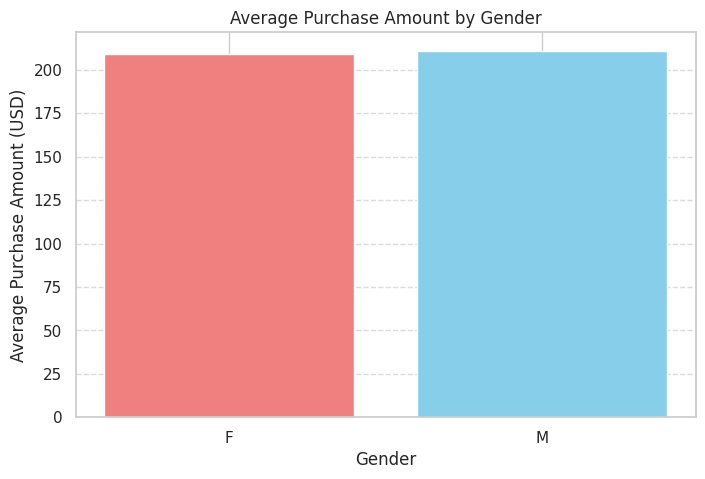

In [ ]:
avg_gender_performance = data.groupBy("Gender").agg(F.avg("Cost_of_the_Product").alias("avg_purchase_amount"))
avg_gender_performance_pd = avg_gender_performance.toPandas()
plt.figure(figsize=(8, 5))
plt.bar(avg_gender_performance_pd['Gender'], avg_gender_performance_pd['avg_purchase_amount'], color=['lightcoral', 'skyblue'])
plt.title('Average Purchase Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Purchase Amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###Shipping Timeliness

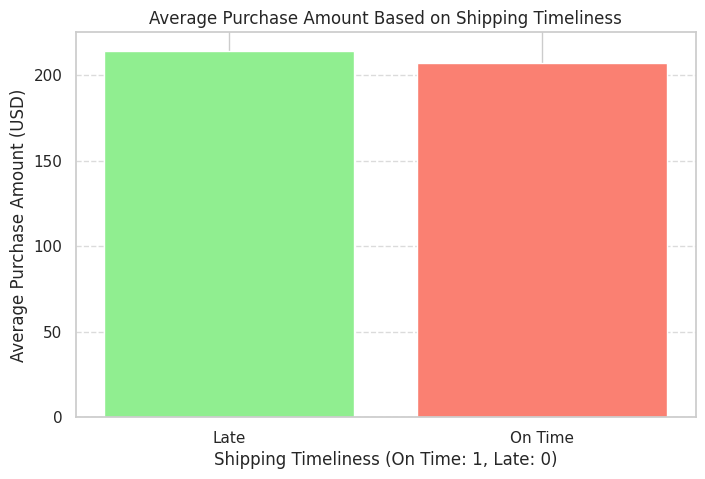

In [ ]:
avg_shipping_timeliness = data.groupBy("`Reached.on.Time_Y.N`").agg(F.avg("Cost_of_the_Product").alias("avg_purchase_amount"))
avg_shipping_timeliness_pd = avg_shipping_timeliness.toPandas()
plt.figure(figsize=(8, 5))
plt.bar(avg_shipping_timeliness_pd['Reached.on.Time_Y.N'], avg_shipping_timeliness_pd['avg_purchase_amount'], color=['lightgreen', 'salmon'])
plt.title('Average Purchase Amount Based on Shipping Timeliness')
plt.xlabel('Shipping Timeliness (On Time: 1, Late: 0)')
plt.xticks([0, 1], ['Late', 'On Time'])
plt.ylabel('Average Purchase Amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###Weight and Purchase Cost

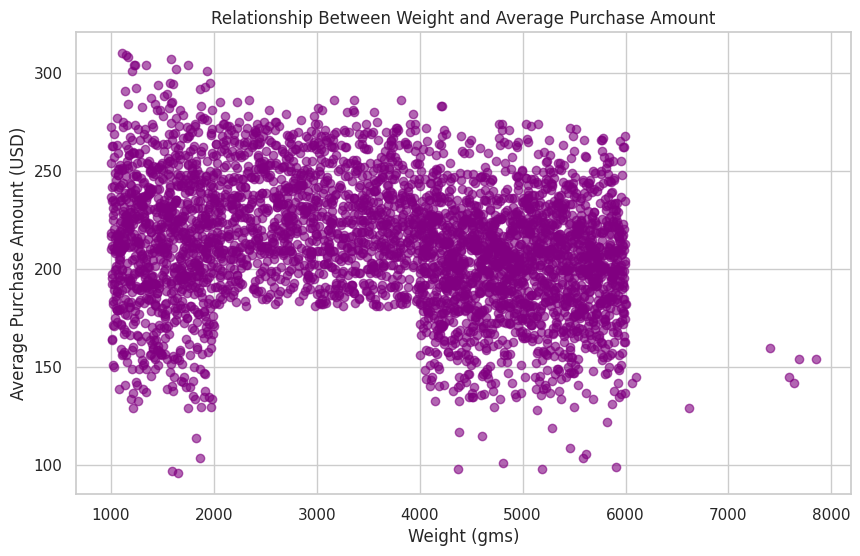

In [ ]:
avg_weight_performance = data.groupBy("Weight_in_gms").agg(F.avg("Cost_of_the_Product").alias("avg_purchase_amount"))
avg_weight_performance_pd = avg_weight_performance.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(avg_weight_performance_pd['Weight_in_gms'], avg_weight_performance_pd['avg_purchase_amount'], color='purple', alpha=0.6)
plt.title('Relationship Between Weight and Average Purchase Amount')
plt.xlabel('Weight (gms)')
plt.ylabel('Average Purchase Amount (USD)')
plt.grid(True)
plt.show()


##Predictions

In [ ]:
from pyspark.sql.functions import when

# Create a new column based on Cost_of_the_Product changes
data = data.withColumn("Purchase_Trend", when(col("Cost_of_the_Product") >= 100, 1).otherwise(0))


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Index categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(data)
            for column in ["Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"]]

# Assemble features into a single vector
feature_columns = ["Warehouse_block_index", "Mode_of_Shipment_index", "Product_importance_index", "Gender_index",
                   "Customer_care_calls", "Customer_rating", "Cost_of_the_Product", "Prior_purchases",
                   "Discount_offered", "Weight_in_gms"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


In [ ]:
from pyspark.ml.classification import LogisticRegression

# Initialize the classifier
lr = LogisticRegression(labelCol="Purchase_Trend", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=indexers + [assembler, lr])

# Split data into training and testing
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model = pipeline.fit(train_data)


In [ ]:
# Predict on test data
predictions = model.transform(test_data)

# Show predictions
predictions.select("features", "Purchase_Trend", "prediction").show(5)


+--------------------+--------------+----------+
|            features|Purchase_Trend|prediction|
+--------------------+--------------+----------+
|[2.0,1.0,0.0,1.0,...|             1|       1.0|
|[1.0,1.0,0.0,0.0,...|             1|       1.0|
|[2.0,1.0,0.0,0.0,...|             1|       1.0|
|[0.0,1.0,2.0,1.0,...|             1|       1.0|
|[0.0,0.0,1.0,1.0,...|             1|       1.0|
+--------------------+--------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Purchase_Trend")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9999738562091502


In [ ]:
# Export the predictions to a CSV file
predictions.select("Purchase_Trend", "prediction").write.csv("predictions.csv", header=True)


In [ ]:
% Load the predictions CSV
data = readtable('predictions.csv');

% Extract the actual and predicted values
actual = data.Purchase_Trend;
predicted = data.prediction;


UsageError: Line magic function `%` not found.
